# Image classification with a quantum-classical hybrid approach

This tutorial will give an introduction to a hybrid approach of performing image classification with quantum classifiers, which is scalable on the current Noisy Intermediate-Scale Quantum (NISQ) hardware. 
The hybrid classification task consists of two steps : 

**1. Dimensionality Reduction with classical method**  : Extract essential features from the input image data.

**2. Feature classification with quantum classifier** : Utilize a quantum classifier for image classification.

<img src="https://drive.google.com/uc?export=view&id=1W0jpYUX44VdHXTimlraB_nrTJTXEl82V" alt="TrainingSchema" width = 700> </a>

The code is written in [PyTorch](link_to_pytorch) for dimensionality reduction and in [Jax](https://github.com/google/jax) and [PennyLane](https://github.com/PennyLaneAI/pennylane) for quantum operations.

In [3]:
import sys 
import os
sys.path.append("../src/")

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import colors

import torch
import numpy as np

## Step0. Loading the Dataset

To begin our project, we initiate the data loading process using the function ``load_data``. Currently, you have access to several image datasets including the following options:

* [**MNIST**](https://www.tensorflow.org/datasets/catalog/mnist) : Grayscale handwritten digits, each of size $(28 \times 28)$, categorized into 10 classes. 
* [**FashionMNIST**](https://www.tensorflow.org/datasets/catalog/fashion_mnist) : Grayscale fasion images, each of size $(28 \times 28)$, categorized into 10 classes. 
* [**SAT4**](https://www.tensorflow.org/datasets/catalog/fashion_mnist) : Satellite land cover images, each of size $(28 \times 28)$ and 4 channels (RGB and near Infrared), categorized into 4 classes. 
* [**EuroSAT**](https://github.com/phelber/EuroSAT) : 
Satellite land cover images, each of size $(64 \times 64)$ and 4 channels (RGB), categorized into 10 classes. 

In [4]:
from dimen_red.load_data import load_data

In [48]:
root = "data"
data = "EuroSAT"

# Load train and test dataset 
trainds, testds = load_data(root, data, download=True)
classes_names = trainds.classes

print(trainds)

Dataset EuroSAT
    Number of datapoints: 21600
    Root location: data
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Let's display the loaded images and their corresponding labels. 

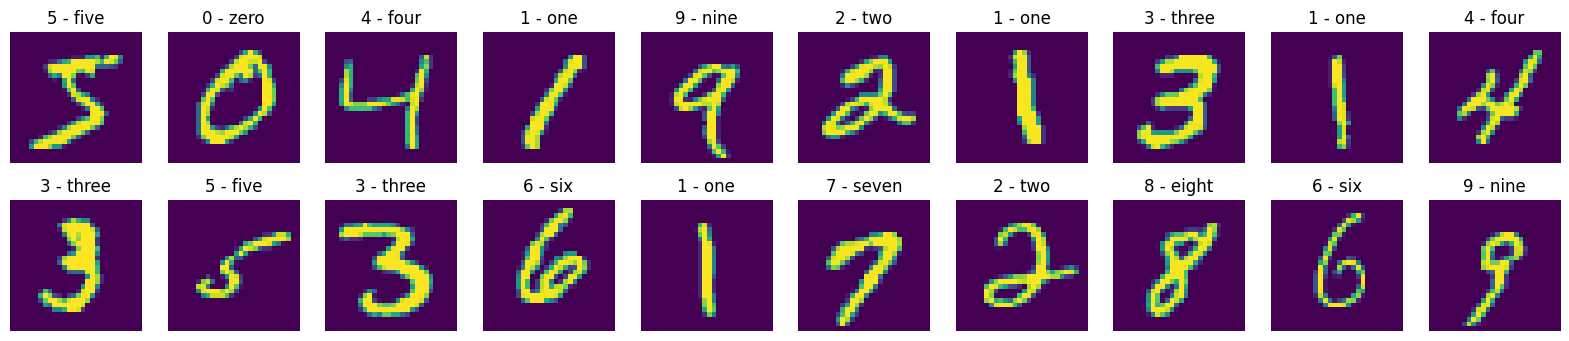

In [34]:
fig, axes = plt.subplots(2, 10, figsize = (20, 4))

for ax, img, label in zip(axes.flatten(), trainds.data, trainds.targets) : 
    if len(img.shape) > 3 : 
        ax.imshow(img[:, :, :3])
    else : 
        ax.imshow(img)
    ax.axis("off")
    ax.set_title(classes_names[label])

## Step1. Classical Dimensionality Reduction



### PCA

Principal Component Analysis is one of the most widely used dimensionality reduction methods that allows to simplify large datasets while maintaning as much information as possible. PCA involves the following steps :

1. **Standarization** : We *standarize* the features to prevent from biased by renormalizing the data variables on the same scale. Let us call $x_j$ the $j$-th variable in the input data $\mathbf{x}$,  $\mu$ the mean and $\sigma$ the standard deviation. Then the renormalized data is given as :

$$
z_j = \frac{x_j - \mu}{\sigma}.
$$

2. **Covariance Matrix Computation** : Once the data is standarized, we compute the covariance matrix $\Sigma = \mathbf{z} \mathbf{z}^T $ based on the standarized variables $\mathbf{z}$ to quantify the correlation between the variables. As the covariance matrix is symmetric by its construction, it is orthogonally diagonalizable with real eigenvalues.

3. **Eigenvector Computation** : We perform the eigen decomposition of $\Sigma$ to find its eigenvectors and eigenvalues $\lambda_1,...,\lambda_p$ (in descending order). Especially, the eigenvalues encode the variability of the data in the direction of the eigen vectors.

4. **Dimensionality Reduction** : PCA uses a subset of the eigenvectors to reduce the dimensionality of the data. Among $p$ eigenvectors, we select the first $k$ eigenvectors, which have the largest corresponding eigenvalues as they capture the most important information in the data. The selected eigenectors are recasted into a matrix $P$. By projecting the original data onto the matrix eigenvectors, so called *Principal Component Axes*, we create a new dataset with reduced dimension $k$ :
$$
\mathbf{x'} = P\cdot \mathbf{z}
$$


In [35]:
from sklearn.decomposition import PCA

For PCA, we need to flatten all the data into one dimensional vectors. 

In [49]:
X_train = trainds.data.reshape((len(trainds), -1))
X_train = X_train.numpy() if type(X_train) == torch.Tensor else X_train

# If the images are scaled between 0 and 255, rescale them between 0 and 1.
if np.max(X_train) > 1.0:
    X_train = X_train / 255.0
Y_train = (trainds.targets.numpy() if type(trainds.targets) == torch.Tensor else trainds.targets)

X_test = testds.data.reshape((len(testds), -1))

X_test = X_test.numpy() if type(X_test) == torch.Tensor else X_test
if np.max(X_test) > 1.0:
    X_test = X_test / 255.0
Y_test = (testds.targets.numpy() if type(testds.targets) == torch.Tensor else testds.targets)

In [50]:
n_components = 16
pca = PCA(n_components=n_components)

pca = pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
Y_train_pca = Y_train
Y_test_pca = Y_test

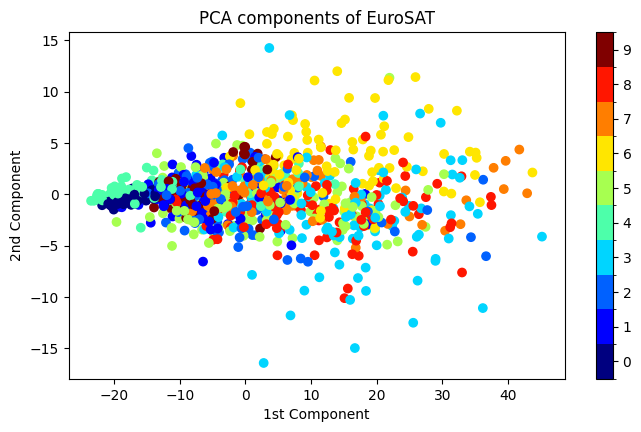

In [51]:
fig = plt.figure(figsize = (8, 4.5))
cmap = plt.cm.jet
norm = colors.BoundaryNorm(np.arange(-0.5, 10.5, 1), cmap.N)


plt.scatter(X_train_pca[:1000,0], X_train_pca[:1000, 1], c = Y_train[:1000],  cmap=cmap, norm=norm)
plt.colorbar(ticks=np.linspace(0, 9, 10))

plt.title(f"PCA components of {data}")
plt.xlabel(f"1st Component")
plt.ylabel(f"2nd Component");

**To Do** : Reduce the original image into vectors of different sizes. 

### Convolutional Autoencoder

Autoencoder is an artificial neural network used for feature learning and dimensionality reduction. The main idea of the autoencoder is to encode the input data into a *latent feature* or *code* in a lower dimensional latent space with the **encoder**, and decodes it back to reconstructs the original data with the **decoder**. The neural networks are optimized by minimizing the reconstruction loss, for which we use the **Mean Squared Loss** in general.
<center>
<figure>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png" width = 500>
    <center><figcaption><b>Fig.2 - Schematic diagram of Autoencoder [<a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
">ref</a>].</b></figcaption></center>

</figure>
</center>

In this tutorial, we specifically use *Convolutional Autoencoder*, where the encoder and the decoder consist of 2-dimensional [convolutional layers](https://cs231n.github.io/convolutional-networks).

In [52]:
from dimen_red.ae_vanilla import vanilla_autoencoder

For training the autoencoder, we need to define the training hyperparameters :  

* ``batch_size`` : The batch size used in autoencoder. 
* ``num_epochs`` : Number of training epochs to run. 
* ``learning_rate`` : Optimizer learning rate.  
* ``b1`` : $\beta_1$ hyperparameter for Adam optimizer. Defaults to 0.9. 
 


In [53]:
num_epoch = 5
batch_size = 1024
learning_rate = 0.001 
b1 = 0.9

In [54]:
# Load the data into PyTorch dataloader.
trainloader = torch.utils.data.DataLoader(
    trainds, batch_size=batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testds, batch_size=batch_size, shuffle=True
)

In [55]:
img_shape = np.array(trainds.data.shape[1:])
if len(img_shape) == 2 : 
    img_shape = [1, img_shape[0], img_shape[1]]
elif len(img_shape) == 3 : 
    img_shape = [img_shape[2], img_shape[0], img_shape[1]]
    
hp = {"model_params" : {"nz" : n_components, "img_shape": img_shape}, 
      "optim_params" : {"lr" : learning_rate, "betas" : (b1, 0.999)}}


# Device to run the training. If the gpu is available, use gpu; otherwise, use cpu. 
device = torch.device(
    "cuda:1"  if torch.cuda.is_available() else "cpu"
)

print(device)

cuda:1


In [56]:
model = vanilla_autoencoder(device, hp, None)

In [57]:
model.train_model(num_epoch, trainloader, testloader)

model.load_state_dict(model.best_model)
X_train_ae, recons_image, Y_train_ae = model.predict(trainloader)
X_test_ae, recons_image, Y_test_ae= model.predict(testloader)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.72batch/s]


New min: 1.00e+04
Epoch : 1/5, Train loss (average) = 0.01627718
Epoch : 1/5, Valid loss = 0.02206395


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 22/22 [00:06<00:00,  3.63batch/s]


New min: 2.21e-02
Epoch : 2/5, Train loss (average) = 0.01328336
Epoch : 2/5, Valid loss = 0.01095707


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.74batch/s]


New min: 1.10e-02
Epoch : 3/5, Train loss (average) = 0.01069151
Epoch : 3/5, Valid loss = 0.01000868


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.74batch/s]


New min: 1.00e-02
Epoch : 4/5, Train loss (average) = 0.01002231
Epoch : 4/5, Valid loss = 0.00940419


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.73batch/s]


New min: 9.40e-03
Epoch : 5/5, Train loss (average) = 0.00920784
Epoch : 5/5, Valid loss = 0.00766129


### Compare the reconstructed images

Let's compare the compression and reconstruction performance of *PCA* and *convolutional autoencoder*. 

In [60]:
img_batch, label = next(iter(testloader))

# PCA
recons_image_pca = pca.inverse_transform(pca.transform(img_batch.reshape(-1, img_shape[0]*img_shape[1]*img_shape[2])))
recons_image_pca = recons_image_pca.reshape(-1, img_shape[0], img_shape[1], img_shape[2])

# Autoencoder
_, recons_image_ae = model(img_batch.to(device).float())
recons_image_ae = recons_image_ae.cpu().detach().numpy()  

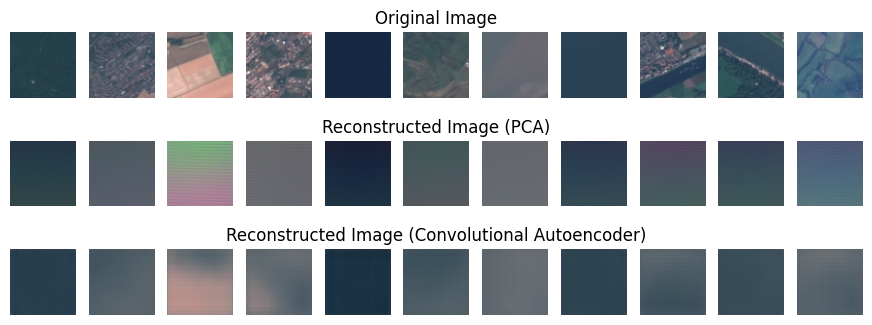

In [61]:

fig, axes = plt.subplots(3, 11, figsize = (11, 4))

for i in range(11) :
    axes[0][i].imshow(np.transpose(img_batch[i][:3], (1, 2, 0)))
    axes[0][i].axis("off")
axes[0][5].set_title("Original Image")
    
for i in range(11) :
    axes[1][i].imshow(np.transpose(recons_image_pca[i][:3], (1, 2, 0)))
    axes[1][i].axis("off")
axes[1][5].set_title("Reconstructed Image (PCA)")

for i in range(11) :
    axes[2][i].imshow(np.transpose(recons_image_ae[i][:3], (1, 2, 0)))
    axes[2][i].axis("off")
axes[2][5].set_title("Reconstructed Image (Convolutional Autoencoder)"); 


## Step2. Feature classification with quantum classifier

Now, we perform the classification of reduced features using quantum classifier. In this tutorial, we will construct a quantum classifier with 8 qubits using [PennyLane](https://github.com/PennyLaneAI/pennylane) for quantum operations and [Jax](https://github.com/google/jax) for vectorization of the operations. 


In [21]:
import pennylane as qml 
import jax
import optax
from jax import Array

In [22]:
num_qubits = 8 
wires = np.arange(num_qubits)


### Quantum Embedding
As our input data are classical, we need to embed the classical data $\mathbf{x}$ into a $n$-qubit quantum circuit by transforming it into a quantum state $|{\psi(\mathbf{x})}\rangle$ in the $2^n$ dimensional Hilbert space $\mathcal{H}$ via a *quantum embedding method*. The most commonly used quantum embedding types are **Amplitude embedding** and **Angular embedding**. 

1. **Amplitude Embedding**: In amplitude embedding, each pixels are embedded as the amplitude of each computational basis states : 

$$  
|{\psi(\mathbf{x})}\rangle = \frac{1}{|\mathbf{x}|}\sum_{i=0}^{N-1} x_i |i\rangle
$$ 
where $|\mathbf{x}|$. Amplitude embedding uses only $\log(N)$ qubits for $N$-dimension data, allowing the exponential compression of data, but requires $\text{poly}(N)$ gates leading to the increase of quantum noises in the real quantum hardware. 


2. **Angular Embedding**: In angular embedding, each pixels are embedded as the angles of the rotation gates applied on each qubits: 

$$  
|{\psi(\mathbf{x})}\rangle = \Big(\bigotimes_{i=1}^n R_y(x_{i+n}) R_x(x_{i})\Big)|0\rangle^{\otimes n }
$$ 

In [23]:
def get_data_embedding(method, wires) : 
    if method == "Angular" : 
        def quantum_embedding(X) : 
            qml.AngleEmbedding(X[:len(X)//2], wires = wires, rotation='X')
            qml.AngleEmbedding(X[len(X)//2:], wires = wires, rotation='Y')
    elif method == "Amplitude" : 
        def quantum_embedding(X) : 
            qml.AmplitudeEmbedding(X, wires = wires)
    else : 
        raise NotImplementedError("Quantum Embedding method not implemented")
    
    return quantum_embedding

In [24]:
embedding_method = "Angular"
embedding_circuit = get_data_embedding(embedding_method, wires)

### Quantum Convolutional Neural Networks
In this tutorial, we use [Quantum Convolutional Neural Networks](https://doi.org/10.1038%2Fs41567-019-0648-8) as the quantum  classifier.

<center>
<img src="https://drive.google.com/uc?export=view&id=1N3dYlUqgeDXS3oJtbQ77Ms-86GXvJoOG" alt="QCNN" width = 500> </a>
<figcaption><b>Fig.3 - Quantum Convolutional Neural Network [<a href="https://ieeexplore.ieee.org/document/9883992/">ref</a>]
</b>
</center>
QCNN consists of two components :

1. **Convolutional filters** : Two-qubit parameterized quantum circuit acting on neighbouring pairs of qubits.
2. **Pooling Layers** : Two-qubit quantum operation used to reduced the two-qubit state into one-qubit state.

Thanks to hierarchical architecture, QCNN contains only $\mathcal{O}(\log n)$ depth, which can be efficiently simulated on the real quantum hardware. Another particularity of QCNN is that it convserves translational invariance by sharing the identical parameters among all ther filters inside each layers.


In our tutorial, we disposes some convolutional filters which are already coded. Let's start by visualizing some of the predefined filters (introduced in the paper [*Quantum convolutional neural network for classical data classification*](https://link.springer.com/article/10.1007/s42484-021-00061-x) by T. Hur, L. Kim and D. K. Park).


In [25]:
from quantum_classifier.models.QuantumCircuit.qcnn import _valid_gates, choose_gate

In [26]:
# Print predifined filters 
print('List of predefined convolutional filters : ')
for gate_name, gate in _valid_gates.items() : 
    if "Pooling" not in gate_name :
        print(f"- {gate_name} filter with {gate[1]} parameters")

List of predefined convolutional filters : 
- RZ filter with 2 parameters
- U_TTN filter with 2 parameters
- U_6 filter with 10 parameters
- U_SO4 filter with 6 parameters
- U_SU4 filter with 15 parameters
- U_ZZ filter with 15 parameters
- U_qiskit filter with 15 parameters
- U_RX filter with 2 parameters


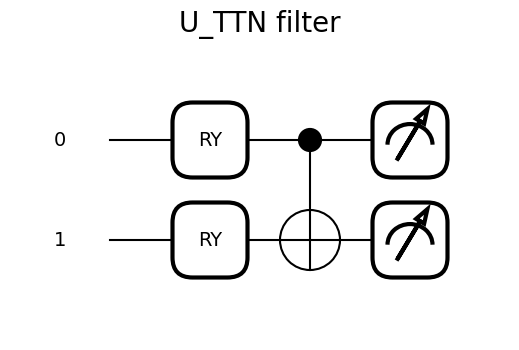

In [27]:
gate_name = "U_TTN" 

_, gate, conv_num_params, num_wires = choose_gate(gate_name)
dev = qml.device("default.qubit", wires = num_wires)

@qml.qnode(dev)
def conv_filter(params): 
    gate(params, [0,1])
    return qml.state() 

qml.draw_mpl(conv_filter)(np.arange(0, conv_num_params));
plt.gca().set_title(f"{gate_name} filter", fontsize = 20);

**To do**: Construct your own convolutional filter. 

In [28]:
def my_filter(params, wires): 
    # To do : Construct your own convolutional filter by filling
    # in the code below. 
    
    qml.RX(params[0], wires[0])
    qml.RX(params[1], wires[1])
    
    
    # ! No measurement ! Do not return ! 

# Save your filter in the format (conv_filter_name, conv_filter_fn, number of parameters, num_of_wires)
conv_filters = ("my_filter", my_filter, 2, 2)

In this tutorial, we disposes a class ``QCNN`` which allows to construct the QCNN architecture either from the predefined convolutional filters, or from the filter that the user contructs. 

In [34]:
from quantum_classifier.models.QuantumCircuit.qcnn import QCNN

In [35]:
# Construct QCNN with the predefined convolutional filter  
qcnn_circuit, num_params, meas_wires = QCNN(num_qubits,1, True, qnn_ver = "U_TTN")


# Uncomment to use your own filter 
# qcnn_circuit, num_params, meas_wires = QCNN(num_qubits,1, True, conv_filters = conv_filters, ppoling = "U_SO4")

We combine the quantum embedding circuit and the QCNN circuit to construct the quantum classifier circuit. To do so, we use [``pennylane.QNode``](https://docs.pennylane.ai/en/stable/code/api/pennylane.QNode.html) class. 

In [36]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

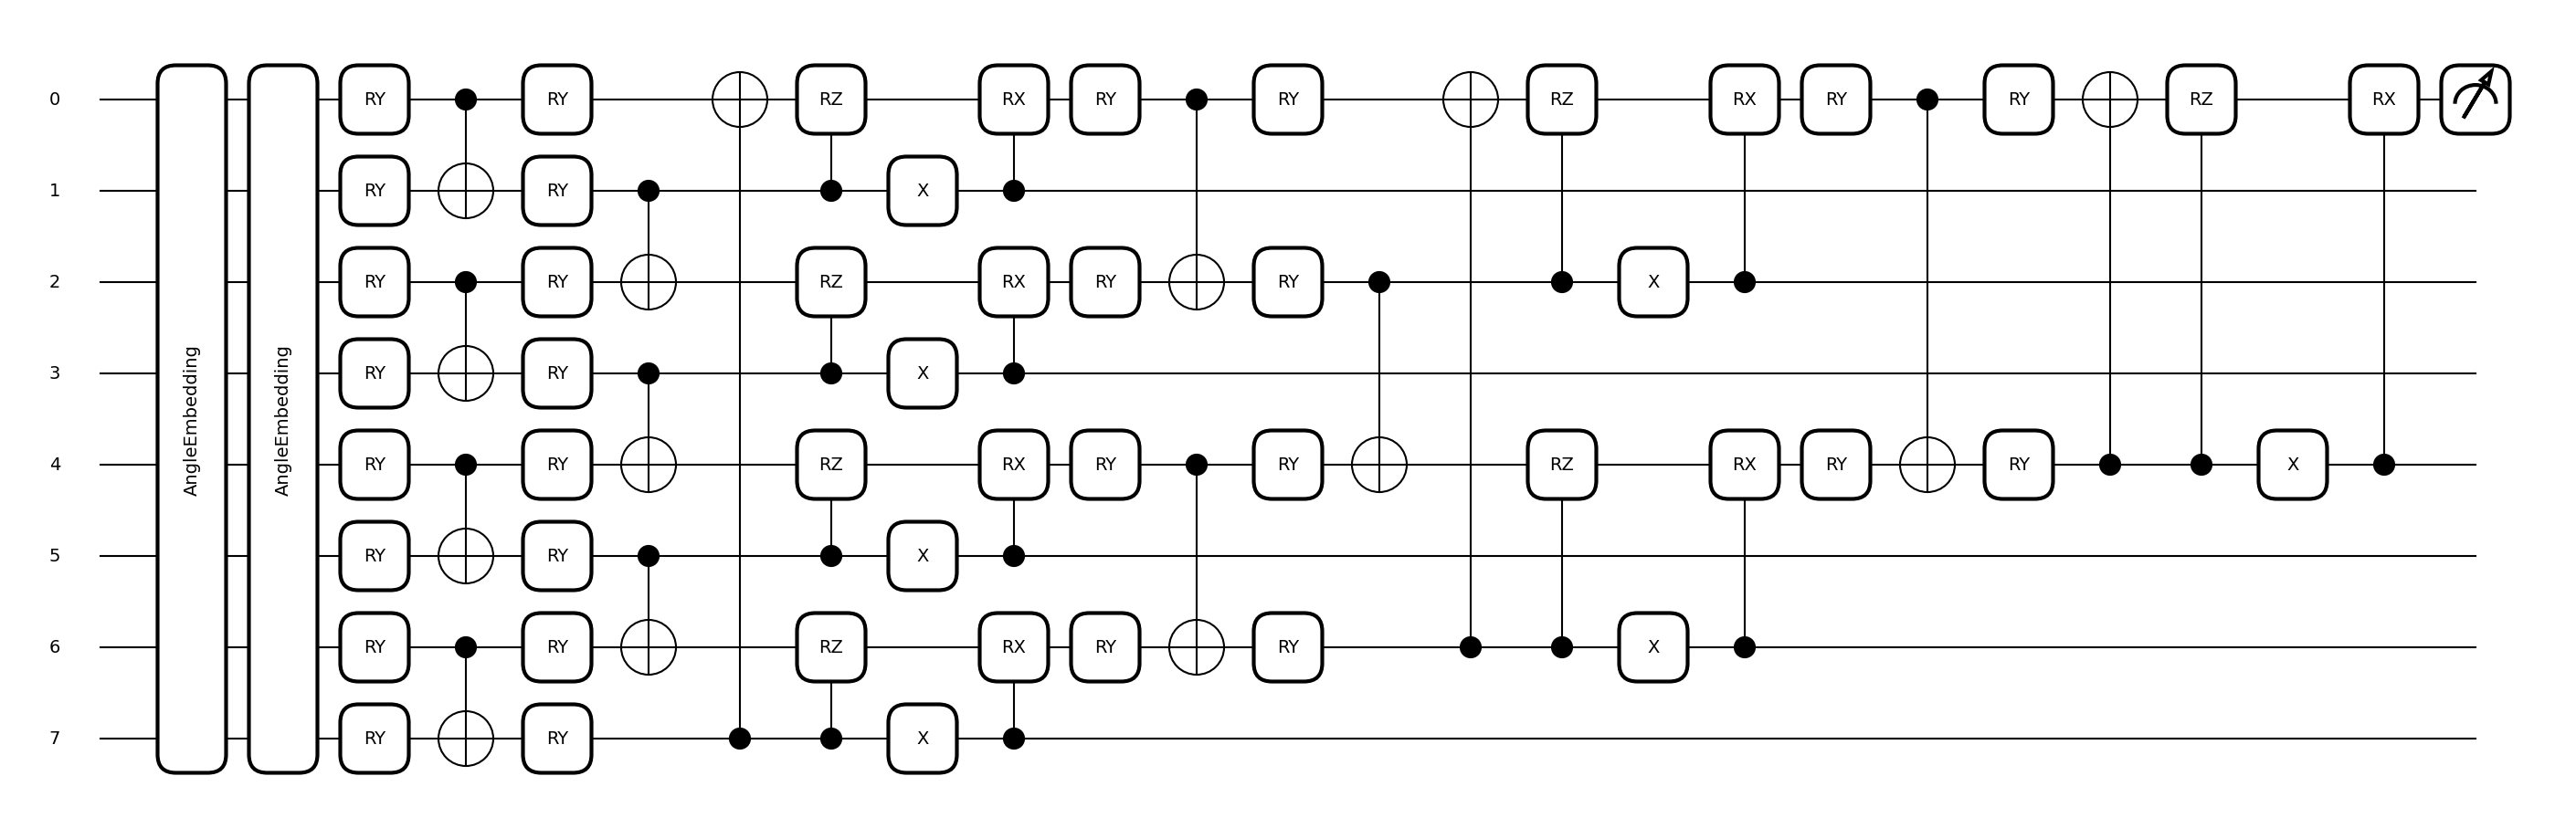

In [37]:
dev = qml.device("default.qubit.jax", wires = num_qubits)

def classifier_circuit(X: Array, params: optax.Params):
        embedding_circuit(X)
        qcnn_circuit(params)

        return qml.probs(meas_wires)

    
quantum_classifier = qml.QNode(classifier_circuit, dev, interface="jax-jit")
qml.draw_mpl(quantum_classifier)(np.arange(n_components), np.arange(num_params));

### Train the model

Now, we train our quantum classifier top perform binary classification of the features extracted from the original data. By default, we use [``optax.adam``](https://optax.readthedocs.io/en/latest/api.html#adam) optimizer. 

In [39]:
from quantum_classifier.models.train import train_batch, validate, train
from quantum_classifier.models.utils import print_losses

from tqdm import tqdm

Let's start by defining the hyperparameters required for quantum circuit training. 

* ``batch_size`` : The batch size used in quantum classifier training. 
* ``num_epochs`` : Number of training epochs to run. 

* ``learning_rate`` : Optimizer learning rate. 
* ``b1`` : $\beta_1$ hyperparameter for Adam optimizer. Defaults to 0.9. 
* ``b2`` : $\beta_2$ hyperparameter for Adam optimizer. Defaults to 0.999. 
 


In [40]:
# Training parameters
batch_size = 144
num_epochs = 20


# Optimizer parameters
learning_rate = 0.01
b1 = 0.9
b2 = 0.99

In [41]:
# Function to train the quantum classifier 
def train(train_ds, test_ds, qnode_circuit): 
    loss_type = ['BCE_loss', 'accuracy']
    seed = np.random.randint(1000)
    seed = 0

    rng = jax.random.PRNGKey(seed)
    rng, init_rng = jax.random.split(rng)   

    params = jax.random.normal(rng, (num_params,))
    rng, init_rng = jax.random.split(rng)
    
    optimizer = optax.adam(learning_rate= learning_rate, b1=b1, b2 = b2)
    opt_state = optimizer.init(params)


    qcircuit = jax.jit(qnode_circuit)
    # Training of model
    train_losses = {k: [] for k in loss_type}
    test_losses = {k: [] for k in loss_type}
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    for epoch in range(num_epochs):
        rng, init_rng = jax.random.split(rng)
        perms = jax.random.permutation(rng, train_ds_size)
        perms = perms[: steps_per_epoch * batch_size]
        perms = perms.reshape((steps_per_epoch, batch_size))

        for k in train_losses.keys():
            train_losses[k].append(0.0)
        with tqdm(perms, unit="batch", desc = "Epoch") as tepoch:
            for perm in tepoch:
                    
                tepoch.set_description(f"Epoch {epoch}")

                batch = {k: v[perm, ...] for k, v in train_ds.items()}

                opt_state, params, losses, class_outputs = train_batch(
                    batch["image"], batch["label"], loss_type, qcircuit, params, optimizer, opt_state,
                )
                
                for k, v in losses.items():
                    train_losses[k][-1] += v.tolist() / steps_per_epoch

        test_loss, test_predictions = validate(
            test_ds["image"], test_ds["label"], loss_type, qcircuit, params  # type: ignore
        )
        
        for k, v in test_loss.items():
            test_losses[k].append(v.tolist())

        print_losses(
            epoch, num_epochs, {k: v[-1] for k, v in train_losses.items()}, test_loss  # type: ignore
        )

    return train_losses, test_losses, test_predictions

Now let's specify two classes on which we would like to perform the binary classification, and the classical dimensionality reduction method used to extract the essential features from the original data.  

* ``classes`` : List of class indexes on which we will perform the binary classification. 
* ``method`` : Dimensionality reduction method used. 


In [42]:
# Specify the classes that we would like to classify and the dimensionality reduction method. 
classes = [0,1]
method = "pca"

In [43]:
if method == "pca" : 
    X_train, Y_train, X_test, Y_test   = X_train_pca, Y_train_pca, X_test_pca,  Y_test_pca
    X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
elif method == "autoencoder" : 
    X_train, Y_train, X_test, Y_test   = X_train_ae, Y_train_ae, X_test_ae,  Y_test_ae
    
mask_train = np.isin(Y_train, classes)
mask_test = np.isin(Y_test, classes)

X_train, Y_train, X_test, Y_test = X_train[mask_train],  Y_train[mask_train], X_test[mask_test], Y_test[mask_test]

for c_pos, c in enumerate(classes):
    Y_train[Y_train == c] = c_pos
    Y_test[Y_test == c] = c_pos

train_ds = {"image" : X_train, "label" : Y_train}
test_ds = {"image" : X_test, "label" : Y_test}

<h1><center> Start training! </center></h1>

In [44]:
 os.environ["CUDA_VISIBLE_DEVICES"] = "3"
    
print(f"Perform binary classification of {classes_names[classes[0]]} and {classes_names[classes[1]]} in",
      f"{data} dataset, reduced with {method}.")

train_loss, test_loss, test_predictions = train(train_ds, test_ds, quantum_classifier) 

Perform binary classification of 0 - zero and 1 - one in MNIST dataset, reduced with pca.


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:12<00:00,  7.03batch/s]


BCE_loss: 0.6598745721510088Epoch : 1/20, Train loss (average) = , accuracy: 0.5373563252646347
BCE_loss: 0.6211217641830444Epoch : 1/20, Valid loss = , accuracy: 0.5962175130844116


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.43batch/s]


BCE_loss: 0.5895204824962837Epoch : 2/20, Train loss (average) = , accuracy: 0.7346743355537284
BCE_loss: 0.553970217704773Epoch : 2/20, Valid loss = , accuracy: 0.86052006483078


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.42batch/s]


BCE_loss: 0.5386658475316807Epoch : 3/20, Train loss (average) = , accuracy: 0.8856960493942787
BCE_loss: 0.5187029838562012Epoch : 3/20, Valid loss = , accuracy: 0.8260047435760498


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.60batch/s]


BCE_loss: 0.5196604269674453Epoch : 4/20, Train loss (average) = , accuracy: 0.9189814884087137
BCE_loss: 0.5089014172554016Epoch : 4/20, Valid loss = , accuracy: 0.9555555582046509


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 29.55batch/s]


BCE_loss: 0.5150353634494474Epoch : 5/20, Train loss (average) = , accuracy: 0.9394157158917392
BCE_loss: 0.5074665546417236Epoch : 5/20, Valid loss = , accuracy: 0.8917257785797119


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.62batch/s]


BCE_loss: 0.5130121348233058Epoch : 6/20, Train loss (average) = , accuracy: 0.9416507092015496
BCE_loss: 0.5055940747261047Epoch : 6/20, Valid loss = , accuracy: 0.9238770604133606


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.51batch/s]


BCE_loss: 0.5106976189832577Epoch : 7/20, Train loss (average) = , accuracy: 0.9453224834354444
BCE_loss: 0.5036470890045166Epoch : 7/20, Valid loss = , accuracy: 0.9716311693191528


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 28.45batch/s]


BCE_loss: 0.5070589058015538Epoch : 8/20, Train loss (average) = , accuracy: 0.9572158428444258
BCE_loss: 0.4991548955440521Epoch : 8/20, Valid loss = , accuracy: 0.978723406791687


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.26batch/s]


BCE_loss: 0.5020881733675111Epoch : 9/20, Train loss (average) = , accuracy: 0.9646392135784543
BCE_loss: 0.49421727657318115Epoch : 9/20, Valid loss = , accuracy: 0.9276595711708069


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.30batch/s]


BCE_loss: 0.4984247886586465Epoch : 10/20, Train loss (average) = , accuracy: 0.9626436836418062
BCE_loss: 0.4910123944282532Epoch : 10/20, Valid loss = , accuracy: 0.945626437664032


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.97batch/s]


BCE_loss: 0.4969642669305035Epoch : 11/20, Train loss (average) = , accuracy: 0.9643199279390532
BCE_loss: 0.49141213297843933Epoch : 11/20, Valid loss = , accuracy: 0.9153664112091064


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 29.30batch/s]


BCE_loss: 0.49687224832074406Epoch : 12/20, Train loss (average) = , accuracy: 0.9620849359994644
BCE_loss: 0.4895787537097931Epoch : 12/20, Valid loss = , accuracy: 0.9758865237236023


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 33.09batch/s]


BCE_loss: 0.4969652291687055Epoch : 13/20, Train loss (average) = , accuracy: 0.9628033288593947
BCE_loss: 0.4899689853191376Epoch : 13/20, Valid loss = , accuracy: 0.9843971729278564


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 33.12batch/s]


BCE_loss: 0.4964955788234187Epoch : 14/20, Train loss (average) = , accuracy: 0.9653576023277194
BCE_loss: 0.48955896496772766Epoch : 14/20, Valid loss = , accuracy: 0.9815602898597717


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 29.72batch/s]


BCE_loss: 0.4964231831588965Epoch : 15/20, Train loss (average) = , accuracy: 0.9642401070430362
BCE_loss: 0.4892271161079407Epoch : 15/20, Valid loss = , accuracy: 0.9602836966514587


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.49batch/s]


BCE_loss: 0.4965163061673614Epoch : 16/20, Train loss (average) = , accuracy: 0.9646392128933436
BCE_loss: 0.48967406153678894Epoch : 16/20, Valid loss = , accuracy: 0.9418439865112305


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.49batch/s]


BCE_loss: 0.4968200623989105Epoch : 17/20, Train loss (average) = , accuracy: 0.9600095858519104
BCE_loss: 0.4892047047615051Epoch : 17/20, Valid loss = , accuracy: 0.9749408960342407


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.56batch/s]


BCE_loss: 0.4965347990222363Epoch : 18/20, Train loss (average) = , accuracy: 0.9667145644111191
BCE_loss: 0.49166759848594666Epoch : 18/20, Valid loss = , accuracy: 0.8917257785797119


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 29.80batch/s]


BCE_loss: 0.4970327146436975Epoch : 19/20, Train loss (average) = , accuracy: 0.9616060071978073
BCE_loss: 0.4894945025444031Epoch : 19/20, Valid loss = , accuracy: 0.958865225315094


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 32.76batch/s]

BCE_loss: 0.4969758175570392Epoch : 20/20, Train loss (average) = , accuracy: 0.9603288653253138
BCE_loss: 0.48958250880241394Epoch : 20/20, Valid loss = , accuracy: 0.9829787015914917


**To Do** : Test different training hyperparameters and dimensionality reduction method to improve the training result. 

## Plot results



In [45]:
import matplotlib.pyplot as plt

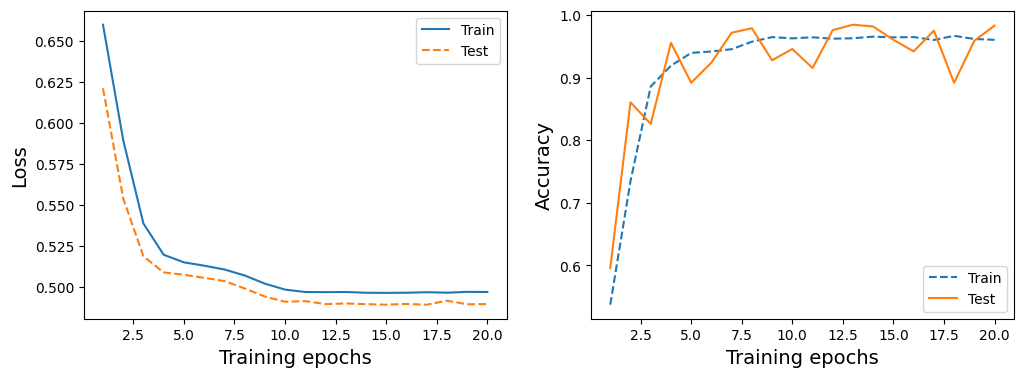

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

epochs = np.arange(len(train_loss['BCE_loss'])) + 1

axes[0].plot(epochs, train_loss['BCE_loss'], label = "Train")
axes[0].plot(epochs, test_loss['BCE_loss'], '--',  label = "Test")
axes[0].set_xlabel("Training epochs", size = 14)
axes[0].set_ylabel("Loss", size = 14)
axes[0].legend(loc = 'best')

axes[1].plot(epochs, train_loss['accuracy'], '--', label = "Train")
axes[1].plot(epochs, test_loss['accuracy'], label = "Test")
axes[1].set_xlabel("Training epochs", size = 14)
axes[1].set_ylabel("Accuracy", size = 14)
axes[1].legend(loc = 'best');


We also draw the confusion matrix for the binary classification. 

In [47]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [48]:
cm = confusion_matrix(Y_test, test_predictions, normalize='true')

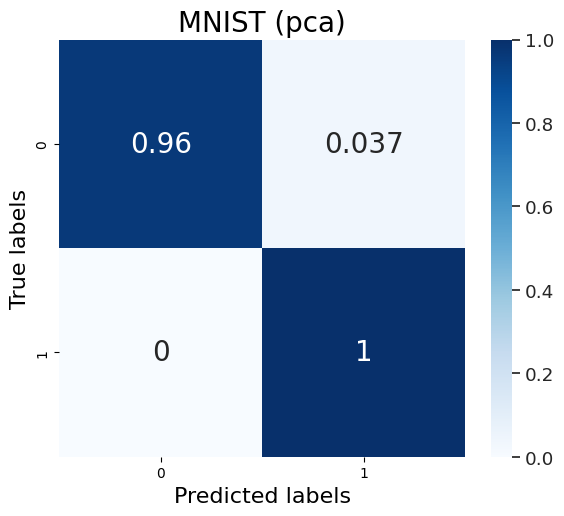

In [49]:
labels = [str(i) for i in classes]
df_cm = pd.DataFrame(cm, labels, labels)
fig, ax = plt.subplots(1,1, figsize = (6,5.4))

sn.set(font_scale=1.2) # for label size
sn.color_palette("Blues", as_cmap=True)

g = sn.heatmap(df_cm, cmap = 'Blues', annot=True, annot_kws={"size": 20}, ax = ax, vmin = 0, vmax = 1.0) # font size

# plt.xticks(rotation = 0)
# plt.yticks(rotation = 90)
plt.title(data + " (" + method + ")", fontsize = 20)
# g.set_yticklabels(labels = labels,va='center', ha='center')

plt.xlabel("Predicted labels", fontsize = 16)
plt.ylabel("True labels", fontsize = 16)
plt.tight_layout()
plt.show()
